In [48]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from esem import gp_model
from esem.utils import get_random_params, leave_one_out, prediction_within_ci
from esem.sampler import MCMCSampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
import sys ; sys.path.append("../../")
from ppe_analysis.analysis import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='05:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.61:34716,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
def normalize(var):
    return (var-min(var))/(max(var)-min(var))

def unnormalize(norm_var,raw_var):
    return norm_var*np.array(max(raw_var)-min(raw_var)) + np.array(min(raw_var))

### load CLM-PPE ensemble

In [6]:
#read in LAI metrics
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')
pft_LAI = ds.TLAI_pft_avg_2003

In [7]:
# get parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [8]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][:17]

### Load CLM5-SP 

In [9]:
# full grid h0 global mean LAI
ds_sp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h0.2000-02-01-00000.nc')
ds_sp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
la=ds_sp.landfrac*ds_sp.area

In [10]:
# load SP on pfts (full grid)
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('./clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

In [11]:
#calculate SP LAI, by pft
lai=amean(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

### Load PPE info

In [12]:
lhckey = '../params/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [76]:
# define target metric (var_raw): sum(global mean annual mean PFT LAI error) 
# all pft's weighted equally

diff = []
for pft in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]: #drop pft 9
#for pft in [4]:
    error = pft_LAI.isel(pft=pft) - laisp[pft]
    diff.append(np.abs(error))
var_raw = np.sum(diff,axis=0)

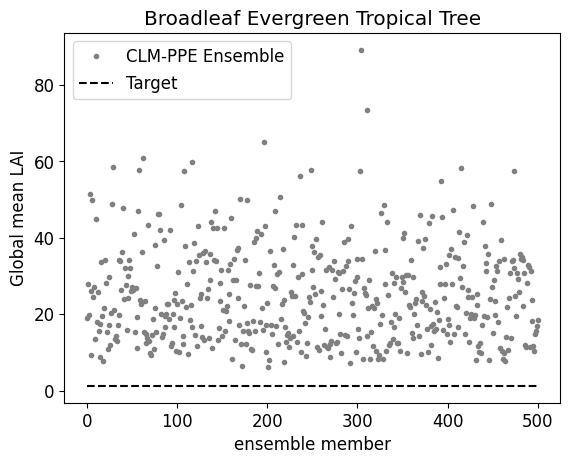

In [77]:
#plt.plot(pft_LAI.isel(pft=pft),'.',color='grey',label='CLM-PPE Ensemble')
plt.plot(var_raw,'.',color='grey',label='CLM-PPE Ensemble')
plt.plot([0,500],[laisp[pft], laisp[pft]],'--',color='k',label='Target')
plt.xlabel('ensemble member')
plt.ylabel('Global mean LAI')
plt.title('Broadleaf Evergreen Tropical Tree')
plt.legend()

In [78]:
var = normalize(var_raw)

n_test = 50 # number of ensemble members to test emulator
Y = var[1:] # target variable excluding default model [0]
default = var[0] # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [79]:
### Linear regression with SciKit learn
model = LinearRegression().fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.coef_)
print(model.intercept_)

0.8182450140020242
[ 0.08907558 -0.03954204  0.03079967  0.01951068  0.03166213  0.02541443
 -0.12295281 -0.00649134 -0.08716135  0.19573985  0.12815296  0.02131701
  0.15930366  0.019983    0.15021552 -0.16399178 -0.08869326  0.08111364
  0.0134707  -0.01610531 -0.03591921  0.01736352  0.06628151 -0.00734662
  0.10913945 -0.00394207 -0.08417839  0.04418641  0.06511853  0.03495518
  0.03006694  0.15178511]
-0.18548394103442845


In [81]:
coefs = pd.DataFrame({'error': np.abs(model.coef_)})
coefs.index = ppe_params.columns
coef_sorted=coefs.sort_values(by='error',ascending=False)

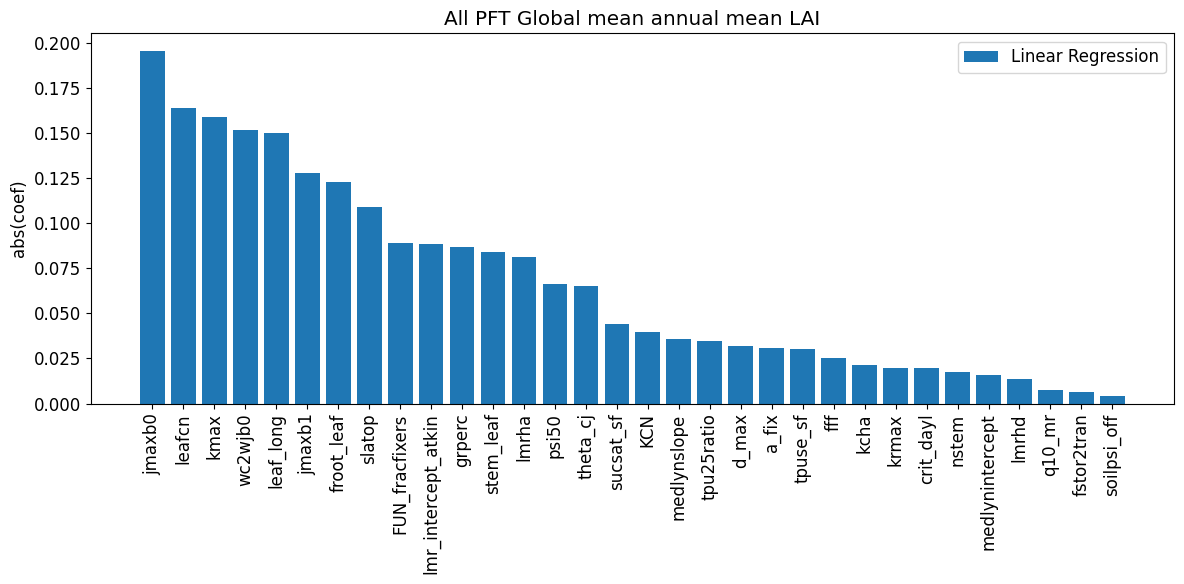

In [83]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(coef_sorted.index,coef_sorted['error'],label='Linear Regression')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('abs(coef)')
plt.title('All PFT Global mean annual mean LAI')
plt.tight_layout()

In [17]:
### LASSO Linear regression with SciKit learn
#model = linear_model.Lasso(alpha=0.0001)
#model.fit(X_train, y_train)

In [90]:
reg_pred = model.predict(X_test)

Text(0, 0.5, 'Linear Regression absolute error')

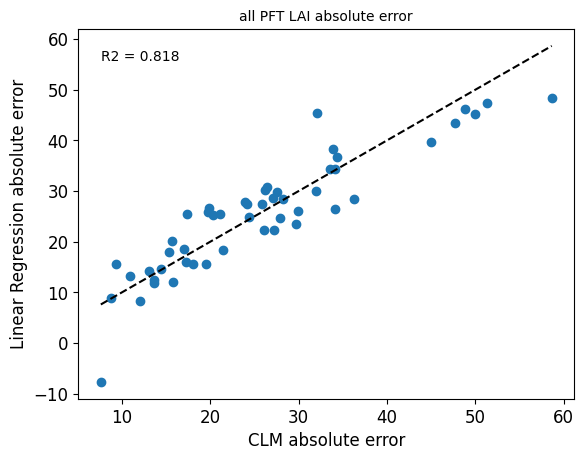

In [91]:
#plot emulator validation
rms = mean_squared_error(y_test, reg_pred, squared=False)
r2 = r2_score(y_test,reg_pred)

y_test_raw = unnormalize(y_test,var_raw)
reg_pred_raw = unnormalize(reg_pred,var_raw)

ax = plt.subplot(1,1,1)
ax.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
ax.scatter(y_test_raw,reg_pred_raw)
ax.text(min(y_test_raw),max(y_test_raw)*0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
ax.set_title('all PFT LAI absolute error',fontsize = 10)
ax.set_xlabel('CLM absolute error')
ax.set_ylabel('Linear Regression absolute error')

### GP emulator (ESEm package uses GPflow

In [84]:
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))

kernel = kernel_linear + kernel_matern32

In [85]:
PFTemulator = gp_model(np.array(X_train),np.array(y_train),kernel=kernel)
PFTemulator.train()

Text(0, 0.5, 'GP emulated absolute error')

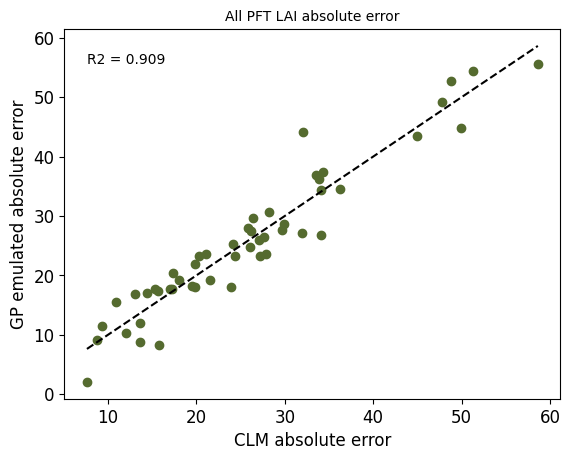

In [86]:
#plot emulator validation
y_pred, y_pred_var = PFTemulator.predict(X_test.values)
rms = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test,y_pred)

y_test_raw = unnormalize(y_test,var_raw)

ax = plt.subplot(1,1,1)
ax.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
ax.scatter(y_test_raw,unnormalize(y_pred,var_raw),color='darkolivegreen')
ax.text(min(y_test_raw),max(y_test_raw)*0.95,'R2 = '+str(np.round(r2,3)),fontsize=10)
ax.set_title('All PFT LAI absolute error',fontsize = 10)
ax.set_xlabel('CLM absolute error')
ax.set_ylabel('GP emulated absolute error')

In [87]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)

In [88]:
Y, _ = PFTemulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
#FAST_sens = pd.DataFrame.from_dict(FAST['S1'])
sens = pd.DataFrame.from_dict(FAST)
sens.index = sens.names
df_sens = sens.sort_values(by=['S1'],ascending=False)

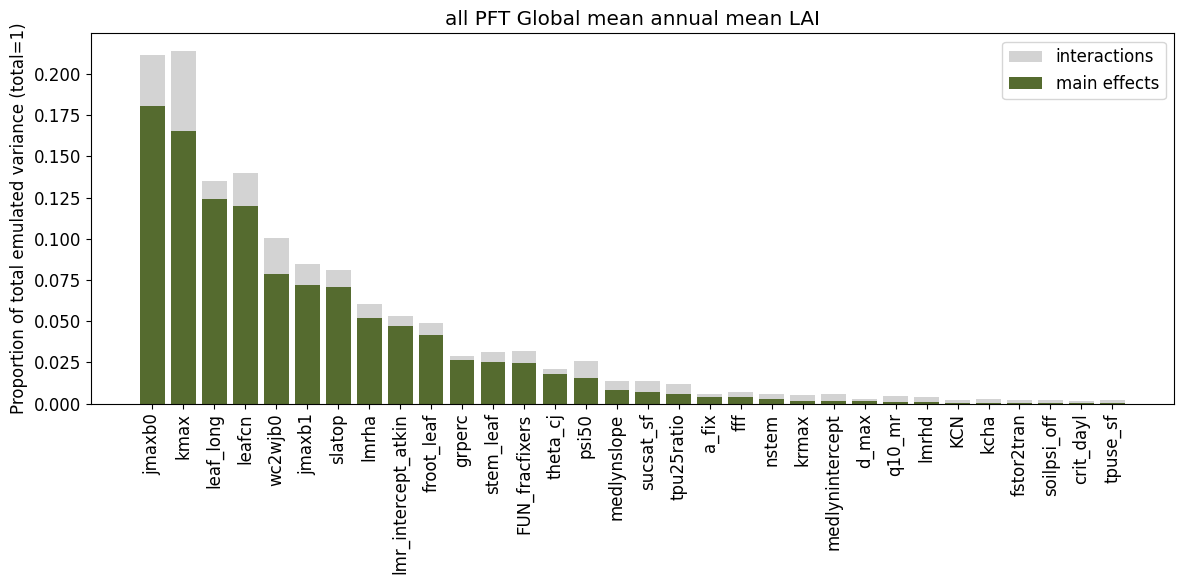

In [89]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('all PFT Global mean annual mean LAI')
plt.tight_layout()
#plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_GPP.png',dpi=200)